# <u>Assignment Speech Recognition :-</u>

# Name : Youssef Mohamed Helmy
# ID   : 2203163
# Department : AI

## Import necessary libraries

In [1]:

import os
import numpy as np
import pandas as pd
import librosa
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


## Kaggle dataset download

In [2]:
# Set up Kaggle API
os.environ['KAGGLE_USERNAME'] = 'youssefhelmy'
os.environ['KAGGLE_KEY'] = 'dab7d1103dbbc2e5f0f9d706ccf1f26b'
# Define the folder path
folder_path = './speech_commands_dataset'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset into our folder
api.dataset_download_files('neehakurelli/google-speech-commands', path=folder_path, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/neehakurelli/google-speech-commands


In [3]:
# Define constants
DATA_DIR = '/content/speech_commands_dataset'  # Directory where the dataset is downloaded
TARGET_CLASSES = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"] # Classes in our Data
TARGET_LENGTH = 64  # Length for MFCC

## Data Augmentations and Defining a Function for Extraction MFCCs Features

In [4]:
# Generate random noise and add it to the audio signal.
def add_random_noise(y, noise_factor=0.005):

    noise = np.random.normal(0, 1, len(y))
    return y + noise * noise_factor

# Apply pitch shift augmentations
def change_pitch(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

# Function for Extract MFCCs Features
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)

    # Apply random noise and pitch shift augmentations
    y_noisy = add_random_noise(y)
    y_pitch_changed = change_pitch(y, sr, n_steps=2)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_noisy = librosa.feature.mfcc(y=y_noisy, sr=sr, n_mfcc=n_mfcc)
    mfcc_pitch_changed = librosa.feature.mfcc(y=y_pitch_changed, sr=sr, n_mfcc=n_mfcc)

    # Function to pad or truncate MFCC
    def pad_or_truncate(mfcc):
        if mfcc.shape[1] > TARGET_LENGTH:
            return mfcc[:, :TARGET_LENGTH]  # Truncate to target_length
        else:
            # Pad with zeros to the right if shorter
            pad_width = TARGET_LENGTH - mfcc.shape[1]
            return np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')

    # Pad or truncate MFCC features to the target length
    mfcc = pad_or_truncate(mfcc)
    mfcc_noisy = pad_or_truncate(mfcc_noisy)
    mfcc_pitch_changed = pad_or_truncate(mfcc_pitch_changed)

    # Stack features
    return np.hstack((mfcc, mfcc_noisy, mfcc_pitch_changed))


## Load data and extract MFCC features

In [5]:
X, y = [], []
labels = os.listdir(DATA_DIR)

# Loop through each label directory
for label in labels:
    if label in TARGET_CLASSES:
        folder_path = os.path.join(DATA_DIR, label)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    mfcc = extract_mfcc(file_path)  # Extract MFCC features with augmentation
                    X.append(mfcc)
                    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples with {len(set(y))} unique labels.")

Loaded 23666 samples with 10 unique labels.


## Encode labels as integers

In [6]:

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


## Split data: 80% train, 10% validation, 10% test

In [7]:

X_temp, X_test, y_temp, y_test = train_test_split(X, y_categorical, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")



Training set shape: (19169, 13, 192), Validation set shape: (2130, 13, 192), Test set shape: (2367, 13, 192)


## Flatten MFCC features for ANN input and normalize

In [8]:

X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0


## Model definition for ANN

In [17]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 1024)                │       2,556,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │             1

 Total params: 3,265,114 (12.46 MB)

 Trainable params: 3,261,050 (12.44 MB)

 Non-trainable params: 4,064 (15.88 KB)


## Train the model

In [18]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.3772 - loss: 1.8241 - val_accuracy: 0.6845 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7327 - loss: 0.8397 - val_accuracy: 0.7911 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7889 - loss: 0.6304 - val_accuracy: 0.7254 - val_loss: 0.8849 - learning_rate: 0.0010
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8138 - loss: 0.5714 - val_accuracy: 0.7765 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8362 - loss: 0.4997 - val_accuracy: 0.8333 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8465 - loss: 0.4686 - val_accuracy: 0.8441 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8537 - loss: 0.4403

## Model evaluation on the test set

In [19]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9293 - loss: 0.2265
Test Loss: 0.2449067234992981
Test Accuracy: 0.9260667562484741


## Generate predictions on the test set

In [20]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


## Evaluation metrics

In [21]:

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9260667511618081
Precision: 0.9271051561074387
Recall: 0.9260667511618081
F1 Score: 0.9260811847035217


## training & validation accuracy and loss Graph

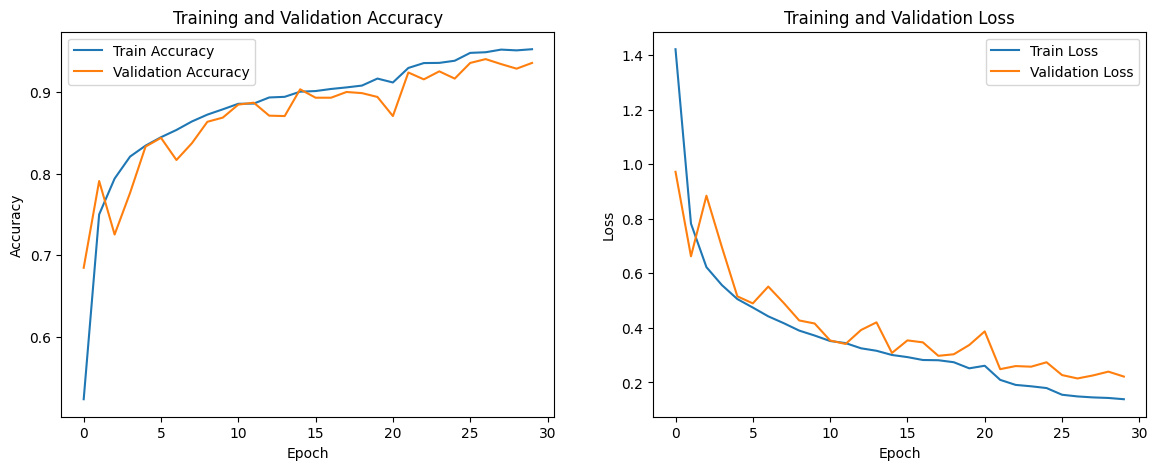

In [22]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## Confusion matrix

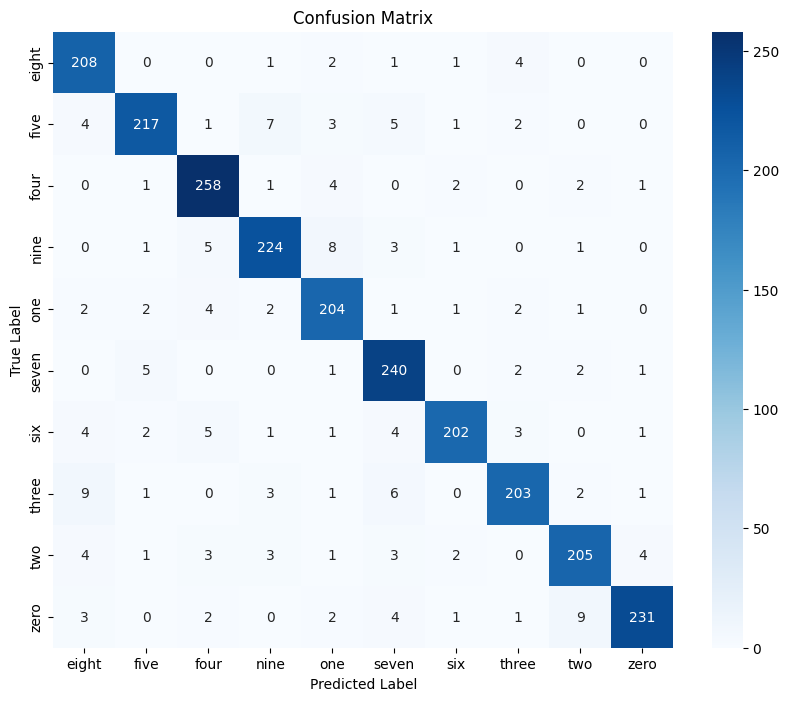

In [23]:

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()